# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels_20percent.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels_20percent.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(25192, 120)

In [4]:
dataset.kdd_test_2labels.shape

(11850, 120)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

preprocess.x_train.shape

(25192, 118)

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 118
    classes = 2
    hidden_encoder_dim = 118
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            #gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            #gradients = [
            #    None if gradient is None else tf.clip_by_value(gradient, -1, 1)
            #    for gradient in gradients]
            #self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_dense_only_nsl_kdd-/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                               net.regularized_loss, 
                                                               ], #net.summary_op
                                                              feed_dict={net.x: x_train[i,:], 
                                                                         net.y_: y_train[i,:], 
                                                                         net.keep_prob:0.5, net.lr:lr})

                        train_batch()
                        #summary_writer_train.add_summary(summary_str, epoch)
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                            print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()


                    valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                          feed_dict={net.x: x_valid, 
                                                                     net.y_: y_valid, 
                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)


                    accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})

                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f} | Test Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy, accuracy))
                   
                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:
                        Train.best_acc = accuracy

                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_dense_only_nsl_kdd-/hidden_layers_{}_features_count_{}".format(h,f),
                                        global_step = epochs)
                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):(curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, accuracy, time.perf_counter() - start_time))})

                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))


In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]
    
    epochs = [30]
    lrs = [1e-2, 1e-5]
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f, lrs)
        

Current Layer Attributes - epochs:30 hidden layers:2 features count:4
Step 1 | Training Loss: 0.430641 | Validation Accuracy: 0.973413 | Test Accuracy: 0.520760
Step 2 | Training Loss: 0.391218 | Validation Accuracy: 0.976587 | Test Accuracy: 0.542194
Step 3 | Training Loss: 0.384016 | Validation Accuracy: 0.978571 | Test Accuracy: 0.535612
Step 4 | Training Loss: 0.341874 | Validation Accuracy: 0.978968 | Test Accuracy: 0.538228
Step 5 | Training Loss: 0.350346 | Validation Accuracy: 0.971429 | Test Accuracy: 0.523376
Step 6 | Training Loss: 0.341239 | Validation Accuracy: 0.976984 | Test Accuracy: 0.536878
Step 7 | Training Loss: 0.331846 | Validation Accuracy: 0.975397 | Test Accuracy: 0.533249
Step 8 | Training Loss: 0.384507 | Validation Accuracy: 0.977778 | Test Accuracy: 0.524135
Step 9 | Training Loss: 0.378061 | Validation Accuracy: 0.973810 | Test Accuracy: 0.520169
Step 10 | Training Loss: 0.357943 | Validation Accuracy: 0.977381 | Test Accuracy: 0.544388
Step 11 | Training 

Step 29 | Training Loss: 0.348669 | Validation Accuracy: 0.980159 | Test Accuracy: 0.525485
Step 30 | Training Loss: 0.366360 | Validation Accuracy: 0.971032 | Test Accuracy: 0.547595
Step 1 | Training Loss: 0.339814 | Validation Accuracy: 0.978968 | Test Accuracy: 0.547595
Step 2 | Training Loss: 0.339817 | Validation Accuracy: 0.971429 | Test Accuracy: 0.547511
Step 3 | Training Loss: 0.357514 | Validation Accuracy: 0.974603 | Test Accuracy: 0.547426
Step 4 | Training Loss: 0.339816 | Validation Accuracy: 0.977778 | Test Accuracy: 0.547426
Step 5 | Training Loss: 0.348666 | Validation Accuracy: 0.974603 | Test Accuracy: 0.547342
Step 6 | Training Loss: 0.348666 | Validation Accuracy: 0.976984 | Test Accuracy: 0.547342
Step 7 | Training Loss: 0.313276 | Validation Accuracy: 0.978571 | Test Accuracy: 0.547342
Step 8 | Training Loss: 0.357514 | Validation Accuracy: 0.978175 | Test Accuracy: 0.547342
Step 9 | Training Loss: 0.366512 | Validation Accuracy: 0.980159 | Test Accuracy: 0.5471

Step 28 | Training Loss: 0.322116 | Validation Accuracy: 0.975397 | Test Accuracy: 0.492489
Step 29 | Training Loss: 0.330965 | Validation Accuracy: 0.976984 | Test Accuracy: 0.492489
Step 30 | Training Loss: 0.348671 | Validation Accuracy: 0.978175 | Test Accuracy: 0.492489
Current Layer Attributes - epochs:30 hidden layers:2 features count:32
Step 1 | Training Loss: 0.322111 | Validation Accuracy: 0.971825 | Test Accuracy: 0.501435
Step 2 | Training Loss: 0.341218 | Validation Accuracy: 0.971825 | Test Accuracy: 0.504641
Step 3 | Training Loss: 0.339810 | Validation Accuracy: 0.977778 | Test Accuracy: 0.523038
Step 4 | Training Loss: 0.330902 | Validation Accuracy: 0.973413 | Test Accuracy: 0.572067
Step 5 | Training Loss: 0.348841 | Validation Accuracy: 0.978175 | Test Accuracy: 0.521097
Step 6 | Training Loss: 0.348660 | Validation Accuracy: 0.975794 | Test Accuracy: 0.470380
Step 7 | Training Loss: 0.356405 | Validation Accuracy: 0.969048 | Test Accuracy: 0.604135
Step 8 | Trainin

Step 26 | Training Loss: 0.468389 | Validation Accuracy: 0.975397 | Test Accuracy: 0.506414
Step 27 | Training Loss: 0.526476 | Validation Accuracy: 0.973016 | Test Accuracy: 0.493840
Step 28 | Training Loss: 0.519948 | Validation Accuracy: 0.961508 | Test Accuracy: 0.500506
Step 29 | Training Loss: 0.586339 | Validation Accuracy: 0.968651 | Test Accuracy: 0.497131
Step 30 | Training Loss: 0.571221 | Validation Accuracy: 0.964683 | Test Accuracy: 0.497046
Step 1 | Training Loss: 0.603076 | Validation Accuracy: 0.968651 | Test Accuracy: 0.497046
Step 2 | Training Loss: 0.548379 | Validation Accuracy: 0.971032 | Test Accuracy: 0.497046
Step 3 | Training Loss: 0.508284 | Validation Accuracy: 0.969048 | Test Accuracy: 0.497046
Step 4 | Training Loss: 0.587206 | Validation Accuracy: 0.966270 | Test Accuracy: 0.497046
Step 5 | Training Loss: 0.562804 | Validation Accuracy: 0.961508 | Test Accuracy: 0.497046
Step 6 | Training Loss: 0.559161 | Validation Accuracy: 0.965873 | Test Accuracy: 0.4

Step 25 | Training Loss: 0.357633 | Validation Accuracy: 0.969841 | Test Accuracy: 0.504894
Step 26 | Training Loss: 0.357664 | Validation Accuracy: 0.975000 | Test Accuracy: 0.504894
Step 27 | Training Loss: 0.375146 | Validation Accuracy: 0.974603 | Test Accuracy: 0.504894
Step 28 | Training Loss: 0.401810 | Validation Accuracy: 0.971825 | Test Accuracy: 0.504894
Step 29 | Training Loss: 0.392871 | Validation Accuracy: 0.971429 | Test Accuracy: 0.504894
Step 30 | Training Loss: 0.348654 | Validation Accuracy: 0.976587 | Test Accuracy: 0.504810
Current Layer Attributes - epochs:30 hidden layers:4 features count:16
Step 1 | Training Loss: 0.328367 | Validation Accuracy: 0.972619 | Test Accuracy: 0.494937
Step 2 | Training Loss: 0.373868 | Validation Accuracy: 0.967063 | Test Accuracy: 0.511814
Step 3 | Training Loss: 0.337695 | Validation Accuracy: 0.966270 | Test Accuracy: 0.511055
Step 4 | Training Loss: 0.348591 | Validation Accuracy: 0.966667 | Test Accuracy: 0.513080
Step 5 | Trai

Step 23 | Training Loss: 0.330961 | Validation Accuracy: 0.965476 | Test Accuracy: 0.549958
Step 24 | Training Loss: 0.348660 | Validation Accuracy: 0.961508 | Test Accuracy: 0.555359
Step 25 | Training Loss: 0.375209 | Validation Accuracy: 0.961905 | Test Accuracy: 0.549451
Step 26 | Training Loss: 0.366359 | Validation Accuracy: 0.962302 | Test Accuracy: 0.555190
Step 27 | Training Loss: 0.348660 | Validation Accuracy: 0.961905 | Test Accuracy: 0.555274
Step 28 | Training Loss: 0.339810 | Validation Accuracy: 0.963889 | Test Accuracy: 0.562532
Step 29 | Training Loss: 0.348660 | Validation Accuracy: 0.937302 | Test Accuracy: 0.551224
Step 30 | Training Loss: 0.410607 | Validation Accuracy: 0.937698 | Test Accuracy: 0.549958
Step 1 | Training Loss: 0.357509 | Validation Accuracy: 0.943254 | Test Accuracy: 0.549958
Step 2 | Training Loss: 0.392908 | Validation Accuracy: 0.931349 | Test Accuracy: 0.549958
Step 3 | Training Loss: 0.384058 | Validation Accuracy: 0.931349 | Test Accuracy: 

Step 22 | Training Loss: 0.506007 | Validation Accuracy: 0.971825 | Test Accuracy: 0.553586
Step 23 | Training Loss: 0.549681 | Validation Accuracy: 0.966667 | Test Accuracy: 0.553586
Step 24 | Training Loss: 0.498148 | Validation Accuracy: 0.968651 | Test Accuracy: 0.553586
Step 25 | Training Loss: 0.529521 | Validation Accuracy: 0.968254 | Test Accuracy: 0.553586
Step 26 | Training Loss: 0.547590 | Validation Accuracy: 0.962302 | Test Accuracy: 0.553586
Step 27 | Training Loss: 0.597178 | Validation Accuracy: 0.965476 | Test Accuracy: 0.553586
Step 28 | Training Loss: 0.566863 | Validation Accuracy: 0.962698 | Test Accuracy: 0.553586
Step 29 | Training Loss: 0.537990 | Validation Accuracy: 0.967857 | Test Accuracy: 0.553586
Step 30 | Training Loss: 0.476947 | Validation Accuracy: 0.967857 | Test Accuracy: 0.553586
Current Layer Attributes - epochs:30 hidden layers:6 features count:8
Step 1 | Training Loss: 0.340600 | Validation Accuracy: 0.975794 | Test Accuracy: 0.500338
Step 2 | Tr

Step 20 | Training Loss: 0.370356 | Validation Accuracy: 0.958333 | Test Accuracy: 0.659325
Step 21 | Training Loss: 0.375328 | Validation Accuracy: 0.965079 | Test Accuracy: 0.648608
Step 22 | Training Loss: 0.357370 | Validation Accuracy: 0.963095 | Test Accuracy: 0.647342
Step 23 | Training Loss: 0.384060 | Validation Accuracy: 0.956746 | Test Accuracy: 0.670886
Step 24 | Training Loss: 0.348753 | Validation Accuracy: 0.958730 | Test Accuracy: 0.674599
Step 25 | Training Loss: 0.330894 | Validation Accuracy: 0.953175 | Test Accuracy: 0.694684
Step 26 | Training Loss: 0.357548 | Validation Accuracy: 0.950397 | Test Accuracy: 0.686582
Step 27 | Training Loss: 0.375243 | Validation Accuracy: 0.964286 | Test Accuracy: 0.657384
Step 28 | Training Loss: 0.357543 | Validation Accuracy: 0.968651 | Test Accuracy: 0.638819
Step 29 | Training Loss: 0.331017 | Validation Accuracy: 0.966667 | Test Accuracy: 0.638734
Step 30 | Training Loss: 0.392908 | Validation Accuracy: 0.966667 | Test Accurac

Step 19 | Training Loss: 0.516802 | Validation Accuracy: 0.941270 | Test Accuracy: 0.628439
Step 20 | Training Loss: 0.543350 | Validation Accuracy: 0.943651 | Test Accuracy: 0.628270
Step 21 | Training Loss: 0.552200 | Validation Accuracy: 0.938492 | Test Accuracy: 0.628186
Step 22 | Training Loss: 0.481403 | Validation Accuracy: 0.947619 | Test Accuracy: 0.628101
Step 23 | Training Loss: 0.561049 | Validation Accuracy: 0.946429 | Test Accuracy: 0.628186
Step 24 | Training Loss: 0.525651 | Validation Accuracy: 0.946825 | Test Accuracy: 0.628270
Step 25 | Training Loss: 0.676094 | Validation Accuracy: 0.939286 | Test Accuracy: 0.628186
Step 26 | Training Loss: 0.543371 | Validation Accuracy: 0.943651 | Test Accuracy: 0.628270
Step 27 | Training Loss: 0.490253 | Validation Accuracy: 0.937302 | Test Accuracy: 0.628354
Step 28 | Training Loss: 0.525651 | Validation Accuracy: 0.945238 | Test Accuracy: 0.628354
Step 29 | Training Loss: 0.578748 | Validation Accuracy: 0.946429 | Test Accurac

In [10]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)

In [11]:
Train.predictions = dict1
Train.results = dict2

In [12]:
df_results = pd.DataFrame(Train.results)

In [13]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,time_taken
10,60,16,6,0.956746,0.696203,15.208156
8,60,4,6,0.959921,0.667257,1.134490
3,60,32,2,0.969048,0.628523,5.512576
11,60,32,6,0.944841,0.628523,22.694904
7,60,32,4,0.961111,0.620000,7.441985
1,60,8,2,0.973810,0.585063,2.194956
6,60,16,4,0.977778,0.579241,4.893374
0,60,4,2,0.980159,0.561519,8.671874
2,60,16,2,0.976190,0.556034,4.747659
5,60,8,4,0.969444,0.546751,6.093898


In [14]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions-.pkl")
df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores-.pkl")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.6658  0.3342]
 [ 0.1668  0.8332]]


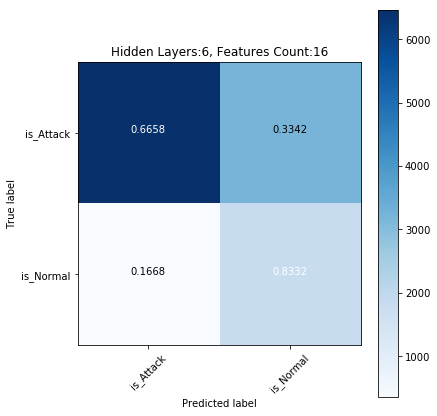

In [16]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)